# Capstone Project - Battle of the Neighborhoods
### _IBM Applied Data Science Capstone_ 
***


## Table of contents
* [Introduction: Business Problem](#intro)
* [Dataset](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction - Business Problem <a name="intro"></a>

**Winnipeg**, a city located in the heart of Canada - Manitoba, will be the focus of this project as we will explore through this 'cool' city for the right location of setting up a restaurant. The findings in this project would be an ideal suit for stakeholders interested in opening a **Lebanese restaurant**

A nice grilled kebob shawarma goes well with the cold eh? Well a nice location makes the experience better. So we are interested in a couple of location categories, for starters we would like to **setup near the city's hub**. An important factor would be to look at **areas with good levels of personal safety** (low crime activity). Watching out for competition too, we would be interested in places with **less restaurants or having no Middle Eastern and Mediterranian restaurants** as these categories match a Lebanese theme. And also being **close to food markets** would make a timely regulation of fresh food items in restaurant service.

Buckle up for this Data-Science journey as we explore through Neighborhoods in the Peg. There will be thorough analysis presented along the way to explain the pros and cons in setting up in certain locations, which would give stakeholders a good idea of candidate locations to setup in.

## Dataset <a name="data"></a>

Here's a list of datasets we will be using for our analysis:

* Geospatial data of the Communities and Neighborhoods in Winnipeg.
* Winnipeg Communties described by varying crime levels.
* Number of restaurants in a neighborhood, with a focus on Middle Eastern restaurants.
* Number of food markets in a Neighborhood.

We would go with the above criteria with the focus on communities and neighborhoods close to the City's hub (Downtown). And the sources we will go to to collect the following datasets are:

* Crimes per Communities data (csv) as reference to a data table from Winnipeg Police's 2018 Annual Report (pg. 13/38)(https://winnipeg.ca/police/AnnualReports/2018/2018_wps_annual_report_english.pdf)
* Geospatial data for both Neighborhoods and Communities will be provided by City of Winnipeg Open Data Portal (https://data.winnipeg.ca/), and lat-long values will be obtained from geocoding with arcGIS.
* Venues with restaurants, their types and food markets in neighborhoods will be obtained using Foursquare API



## Defining Libraries & Functions for our analysis
***
### Importing relevant libraries

In [1]:
import folium #Library for getting maps
import requests #For getting url requests 
import warnings #For ignoring boring warning messages
import descartes #For plotting polygons in geopandas
import numpy as np #For numericals and getting arrays
import pandas as pd #For working with dataframes
import geocoder as gc #For geocoding for lat-long values 
import geopandas as gpd #For working with geo dataframes
import matplotlib.cm as cm #For colormap utilities
import matplotlib.pyplot as plt #For getting matplotlib plots
import matplotlib.colors as colors #For getting plot colors
from sklearn.cluster import KMeans #For using K-Means clustering
from shapely.geometry import Point #For getting Point-geo form values
from shapely.ops import unary_union #For converting MultiPolygon to Polygon values
from IPython.display import display, HTML #For getting display options of dataframes
from math import radians, cos, sin, asin, sqrt #For math calculations 

%matplotlib inline
warnings.filterwarnings('ignore')

### Cool functions that give side-by-side display of dataframes 

In [2]:
#Function that displays DataFrames side-by-side
def sbs(dfs):
    return HTML('<table><tr style="background-color:white;">'+
                ''.join(['<td>'+table._repr_html_()+'</td>' for table in dfs])+
                '</tr></table>')

#Similar to the above, but just a head-tail (of size n rows) display of one dataframe:
def ht(data,size):
    print("{}-row head & tail check for DF of {} rows: Head (left) || Tail (Right)".format(size,data.shape[0]))
    return sbs([data.head(size),data.tail(size)])

### Preprocessing/Transformation functions for our datasets

In [3]:
#Function for preprocessing the Communities data & transforming it's Geo-data 
def preprocess_comms(raw_df):
    #MULTIPOLYGON values converted to POLYGON for the Communities geo-data.
    prep_pd = pd.DataFrame({
    'Communities':[raw_df.name[0],raw_df.name[1], raw_df.name[2], raw_df.name[3],
    raw_df.name[4],raw_df.name[5],raw_df.name[6], raw_df.name[7], raw_df.name[8], 
    raw_df.name[9], raw_df.name[10], raw_df.name[11]], 
    #To get each community's POLYGON form, unary_union function has to be applied.
    'geometry': [unary_union(raw_df.geometry[0]), unary_union(raw_df.geometry[1]),
    unary_union(raw_df.geometry[2]), unary_union(raw_df.geometry[3]), 
    unary_union(raw_df.geometry[4]), unary_union(raw_df.geometry[5]), 
    unary_union(raw_df.geometry[6]), unary_union(raw_df.geometry[7]), 
    unary_union(raw_df.geometry[8]), unary_union(raw_df.geometry[9]), 
    unary_union(raw_df.geometry[10]),unary_union(raw_df.geometry[11])]   })

    #Reordering the dataframe by Communities (alphabetically)
    prep_sort = prep_pd.sort_values(by='Communities')
    preprocessed = prep_sort.reset_index(drop=True) 
    return preprocessed
#______________________________________________________________________________________________________________________________
#Function used for 3 things: Preprocessing the Neighborhoods data,
#Getting each Neighborhood's Lat-Long values, & transforming the geo-data
def preprocess_latlong(df):
    #Preprocessing the Neighborhoods data first
    prep = df.drop(['id','geometry'],1)
    prep.rename(columns={'name':'Neighborhoods'}, inplace=True)
    
    #Now looping for Lat-Long values from Neighborhood names via arcGIS
    for place in prep[prep.columns[0]]:

        geo = gc.arcgis('{} Winnipeg, Manitoba'.format(place))
        coords = geo.latlng
        ind = df.loc[prep[prep.columns[0]] == place].index
        
        #Adding columns of Lat-Long values of the Neighborhoods
        prep.loc[ind,'Latitude'],  prep.loc[ind,'Longitude'] = coords[0], coords[1] 
    
    #Replacing the old geometry with a new POINT form, then applying the DF into a new Geo-DF
    crs = {'init':'epsg:4326'}
    new_geo = [Point(xy) for xy in zip(prep['Longitude'],prep['Latitude'] )]
    new_df = gpd.GeoDataFrame(prep, crs=crs, geometry=new_geo)
    return new_df
#______________________________________________________________________________________________________________________________
#Communties & Neighborhoods transformed geo-data are used to find Neighborhood POINTs (Lat-Long) 
#in each Community's POLYGON (geo-boundary) to group neighborhoods to their respective community.
def classify_neighborhoods(comms_df,nh_df):
    
    #An initial function will get only one Community's grouped Neighborhoods chunk.
    def nh_in_comm(comms_df,nh_df,ind):

        comm_poly = comms_df.ix[comms_df['Communities'] == comms_df['Communities'][ind]]

        if_nh_in_comm = nh_df.within(comm_poly.loc[ind, 'geometry'])
        nh_by_comm = nh_df.loc[if_nh_in_comm] 
        nh_by_comm['Community'] = comms_df['Communities'][ind]
        return nh_by_comm
    
    #The initial function will produce each Community's grouped Neighborhoods, and then we will stack
    #results together. So our new DF will be ordered by Community (alphabetical style). 
    append_royale = nh_in_comm(comms_df,nh_df,0).append(nh_in_comm(comms_df,nh_df,1)).append(
    nh_in_comm(comms_df,nh_df,2)).append(nh_in_comm(comms_df,nh_df,3)).append(
    nh_in_comm(comms_df,nh_df,4)).append(nh_in_comm(comms_df,nh_df,5)).append(
    nh_in_comm(comms_df,nh_df,6)).append(nh_in_comm(comms_df,nh_df,7)).append(
    nh_in_comm(comms_df,nh_df,8)).append(nh_in_comm(comms_df,nh_df,9)).append(
    nh_in_comm(comms_df,nh_df,10)).append(nh_in_comm(comms_df,nh_df,11))
    
    DF = append_royale[['Neighborhoods', 'Community', 'Latitude', 'Longitude','geometry']] #Re-ordering columns
    DF = DF.reset_index(drop=True) #Resetting index
    return DF

### Function for finding Neighborhood distances from a point (the city's hub) 

In [4]:
#Calculates the great-circle distance between two points on earth given with latitudes and longitudes
def haversine(hub_lat, hub_long, nh_lat, nh_long):

    #Converting decimal degrees to radians 
    hub_lat, hub_long, nh_lat, nh_long = map(radians, [hub_lat, hub_long, nh_lat, nh_long])

    #The formula
    dist_lon, dist_lat = nh_long - hub_long, nh_lat - hub_lat  
    a = sin(dist_lat/2)**2 + cos(hub_lat) * cos(nh_lat) * sin(dist_lon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of the Earth in km
    return c * r

### Map functions

In [5]:
#Choropleth map describing crime-levels per Community on the map
def crimes_map(geo_data,choro_data,your_map):
     
    your_map.choropleth(geo_data=geo_data, data=choro_data,
                 columns=['Communities', 'Total_Crimes'],
                 key_on = 'feature.properties.name',
                 fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.5,
                 legend_name='Crimes per Community',
                 reset=True)
    return your_map

#Map of venue locations
def venues_map(df, mapping,color):
    for lat, long, cat, nh in zip(df.Venue_Lat, df.Venue_Long, df.Category, df.Neighborhoods):
        label = folium.Popup(str(cat)+' - '+str(nh),parse_html=True)
        folium.Circle([lat,long], radius=100,popup=label,color=color,
                           fill=True, fill_color=color, fill_opacity=0.5).add_to(mapping)
    return mapping

### Fouresquare API & Venues Functions

In [6]:
def foursquare_api(df):
    #Defining our Foursquare Credentials and Version,
    CLIENT_ID = 'TT4PTM2F0V05FLSPYR01OJK0D3B2Z3Z1KS3VE0BEKORDN0AR' # your Foursquare ID
    CLIENT_SECRET = 'H4C3YADVL4J4PLH4ZRPHZT4ZV4UESF1QGMN5QJBM152XD5ZJ' # your Foursquare Secret
    VERSION = '20191203' 
    radius, LIMIT = 500, 100
    venues = []
    #Looping through the location info. in our DF that will help Foursquare identify venues nearby
    for lat, long, community, neighborhood in zip(df['Latitude'], df['Longitude'], df['Community'], df['Neighborhoods']):

        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']

        for venue in results:
            venues.append((community, neighborhood, lat, long, 
                venue['venue']['name'], venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'], venue['venue']['categories'][0]['name']))
            
    venues_df = pd.DataFrame(venues)
    venues_df.columns = ['Community','Neighborhoods', 'Latitude', 'Longitude', 'Venue', 'Venue_Lat', 'Venue_Long', 'Category']
    return venues_df
#______________________________________________________________________________________________________________________________
def onehot_encode(cat_df):
    #Getting dummies based on categories of venues and adding our columns
    onehot = pd.get_dummies(cat_df[['Category']], prefix="", prefix_sep="")
    onehot['Community'] = cat_df['Community'] 
    onehot['Neighborhoods'] = cat_df['Neighborhoods'] 
    onehot['Latitude'] = cat_df['Latitude']
    onehot['Longitude'] = cat_df['Longitude']

    # Adjusting the above columns to being the first columns in our df
    adjusted = list(onehot.columns[-4:]) + list(onehot.columns[:-4])
    onehot = onehot[adjusted]
    return onehot
#______________________________________________________________________________________________________________________________
#Listing the top 10 most common venues per neighborhood
def most_common_venues(onehot_mean_venues):
    
    #Getting columns that will present most common venues ranking style
    num_top_venues, indicators = 10, ['st', 'nd', 'rd']
    
    areaColumns = ['Community', 'Neighborhoods','Latitude','Longitude']
    freqColumns = []
    for ind in np.arange(num_top_venues):
        try:
            freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            freqColumns.append('{}th Most Common Venue'.format(ind+1))
    columns = areaColumns+freqColumns

    #Getting a new dataframe
    adjust_venues = pd.DataFrame(columns=columns)
    adjust_venues['Community'] = onehot_mean_venues['Community']
    adjust_venues['Neighborhoods'] = onehot_mean_venues['Neighborhoods']
    adjust_venues['Latitude'] = onehot_mean_venues['Latitude']
    adjust_venues['Longitude'] = onehot_mean_venues['Longitude']
    
    #Sorting all columns (most common venues) accordingly
    for ind in range(onehot_mean_venues.shape[0]):
        row_categories = onehot_mean_venues.iloc[ind, :].iloc[4:]
        row_categories_sorted = row_categories.sort_values(ascending=False)
        adjust_venues.iloc[ind, 4:] = row_categories_sorted.index.values[0:num_top_venues]

    adjust_venues.reset_index(drop=True)
    return adjust_venues
#______________________________________________________________________________________________________________________________
def most_common_counts(df):
    #Restaurant category counts among the top 10 most common venues per Neighborhood
    res = df.apply(lambda x: x.str.contains("Restaurant").sum(), axis=1)
    diners = df.apply(lambda x: x.str.contains("Diner").sum(), axis=1)
    joints = df.apply(lambda x: x.str.contains("Joint").sum(), axis=1)
    place = df.apply(lambda x: x.str.contains("Place").sum(), axis=1)

    #Places that could be suppliers to our restaurant 
    supermarkets = df.apply(lambda x: x.str.contains("Supermarket").sum(), axis=1)
    grocery = df.apply(lambda x: x.str.contains("Grocery Store").sum(), axis=1)
    food_drink = df.apply(lambda x: x.str.contains("Food & Drink Shop").sum(), axis=1)
    #Summing all the category counts
    df['All_Restaurants'] = res + diners + joints + place
    df['All_Suppliers'] = supermarkets + grocery + food_drink
    
    #Adjusting columns - Dropping 'Most Common Venues' columns to only display counts of most_common categories
    df = df.drop(df.iloc[:, 4:14], axis = 1)
    return df

## Loading & preprocessing our datasets
***
### Community Crime-levels data: 12 Communities in Winnipeg

In [7]:
#Loading our Community crime-levels data
comm_crime = pd.read_csv("C:/Users/Office/Desktop/PROJECT NEIGHBORHOOD/Community-Crimes-2018.csv")

print('Data on crime levels per community has been loaded.')
ht(comm_crime,6)

Data on crime levels per community has been loaded.
6-row head & tail check for DF of 12 rows: Head (left) || Tail (Right)


,Communities,Total_Crimes
0,Assiniboine South,1339
1,Downtown,17223
2,Fort Garry,3688
3,Inkster,3005
4,Point Douglas,7656
5,River East,4847
,Communities,Total_Crimes
6,River Heights,5365
7,Seven Oaks,4040
8,St. Boniface,3639


### Communities Geospatial data
The data's geometry will be transformed to POLYGON form for classifying Neighborhoods to Communities later.

In [8]:
comms_geo = r'https://data.winnipeg.ca/api/geospatial/d9gq-xua6?method=export&format=GeoJSON'
raw_community = gpd.read_file(comms_geo) #Getting our data in Goepandas form

comms_prep = preprocess_comms(raw_community) #Function for preprocessing the communities data

print('Data on communities geo-locations has been loaded: Raw dataframe (left) || Preprocessed dataframe (right)')
sbs([raw_community,comms_prep])

Data on communities geo-locations has been loaded: Raw dataframe (left) || Preprocessed dataframe (right)


,name,email,contact,id,mobile,phone,geometry
0,Downtown,None,None,11,None,None,"MULTIPOLYGON (((-97.20618 49.88365, -97.20633 ..."
1,Inkster,None,None,9,None,None,"MULTIPOLYGON (((-97.22998 49.96078, -97.22998 ..."
2,Seven Oaks,None,None,8,None,None,"MULTIPOLYGON (((-97.23000 49.97563, -97.22999 ..."
3,River Heights,None,None,12,None,None,"MULTIPOLYGON (((-97.20697 49.85381, -97.20756 ..."
4,Point Douglas,None,None,10,None,None,"MULTIPOLYGON (((-97.17075 49.93265, -97.16690 ..."
5,Transcona,None,None,6,None,None,"MULTIPOLYGON (((-97.07074 49.89522, -97.07117 ..."
6,St. Boniface,None,None,5,None,None,"MULTIPOLYGON (((-97.13736 49.87424, -97.13741 ..."
7,River East,None,None,7,None,None,"MULTIPOLYGON (((-97.12689 49.91503, -97.12695 ..."
8,St. Vital,None,None,4,None,None,"MULTIPOLYGON (((-97.15473 49.77265, -97.15473 ..."
9,Fort Garry,None,None,3,None,None,"MULTIPOLYGON (((-97.22108 49.81437, -97.21965 ..."


### Neighborhoods geospatial data: 237 Neighborhoods in Winnipeg

In [9]:
nh_geo_data = r'https://data.winnipeg.ca/api/geospatial/fen6-iygi?method=export&format=GeoJSON'
raw_neighborhoods = gpd.read_file(nh_geo_data) #Getting our data in Goepandas form

print('Neighborhoods geo data loaded.')
ht(raw_neighborhoods,5) #Head-Tail display of the dataframe by 5 rows each

Neighborhoods geo data loaded.
5-row head & tail check for DF of 237 rows: Head (left) || Tail (Right)


,id,name,geometry
0,1012,Talbot-Grey,"MULTIPOLYGON (((-97.10107 49.90474, -97.10112 ..."
1,1727,Prairie Pointe,"MULTIPOLYGON (((-97.21398 49.76811, -97.18801 ..."
2,1432,Buffalo,"MULTIPOLYGON (((-97.18038 49.82979, -97.17734 ..."
3,759,Rossmere-B,"MULTIPOLYGON (((-97.08240 49.92037, -97.08139 ..."
4,87,Glendale,"MULTIPOLYGON (((-97.32647 49.87836, -97.32679 ..."
,id,name,geometry
232,753,Springfield North,"MULTIPOLYGON (((-97.04852 49.93093, -97.04459 ..."
233,1492,Sir John Franklin,"MULTIPOLYGON (((-97.19436 49.87836, -97.19559 ..."
234,1062,South Point Douglas,"MULTIPOLYGON (((-97.12878 49.89976, -97.12854 ..."
235,45,Woodhaven,"MULTIPOLYGON (((-97.27906 49.87948, -97.27916 ..."


### Lat-Long values for Winnipeg, Downtown & Neighborhoods
Neighborhoods geometry will be replaced with POINT form, as it will be used with Community Polygon boundaries (as mentioned before) in classifying Neighborhoods. All Lat-Long values will be obtained by geocoding with arcGIS

In [10]:
#Getting Winnipeg & Downtown Winnipeg's Lat-Long values
wpg, dt = gc.arcgis('Winnipeg, Manitoba'), gc.arcgis('Downtown Winnipeg, Manitoba')

peglat, peglong = wpg.latlng[0], wpg.latlng[1]
dtlat,dtlong = dt.latlng[0], dt.latlng[1]

#Preprocessing Neighborhoods data and getting the Lat-Long values
nh_df = preprocess_latlong(raw_neighborhoods)

print("Winnipeg's Lattitude & Longitude: {},{}".format(peglat,peglong))
print("Downtown Winnipeg's Lattitude & Longitude: {},{}\n".format(dtlat,dtlong))
print('Lat-Long values for Neighborhoods obtained with new geometry in POINT form.')
ht(nh_df,5) 

Winnipeg's Lattitude & Longitude: 49.89953000000003,-97.14112999999998
Downtown Winnipeg's Lattitude & Longitude: 49.89200000000005,-97.13960999999995

Lat-Long values for Neighborhoods obtained with new geometry in POINT form.
5-row head & tail check for DF of 237 rows: Head (left) || Tail (Right)


,Neighborhoods,Latitude,Longitude,geometry
0,Talbot-Grey,49.90753,-97.091910,POINT (-97.09191 49.90753)
1,Prairie Pointe,49.88430,-97.050375,POINT (-97.05038 49.88430)
2,Buffalo,49.84059,-97.172560,POINT (-97.17256 49.84059)
3,Rossmere-B,49.92665,-97.088640,POINT (-97.08864 49.92665)
4,Glendale,49.87627,-97.321640,POINT (-97.32164 49.87627)
,Neighborhoods,Latitude,Longitude,geometry
232,Springfield North,49.94123,-97.04687,POINT (-97.04687 49.94123)
233,Sir John Franklin,49.87093,-97.20034,POINT (-97.20034 49.87093)
234,South Point Douglas,49.90398,-97.12954,POINT (-97.12954 49.90398)
235,Woodhaven,49.87423,-97.27322,POINT (-97.27322 49.87423)


### Classifying Neighborhoods to their Community 
A function will identify Neighborhood POINTS within  each Community's POLYGON. We get a dataframe grouped by community

In [11]:
nh_by_comm = classify_neighborhoods(comms_prep,nh_df) #Function for the mentioned task

ht(nh_by_comm,5)

5-row head & tail check for DF of 237 rows: Head (left) || Tail (Right)


,Neighborhoods,Community,Latitude,Longitude,geometry
0,River West Park,Assiniboine South,49.86853,-97.31940,POINT (-97.31940 49.86853)
1,Roblin Park,Assiniboine South,49.85159,-97.29022,POINT (-97.29022 49.85159)
2,Ridgewood South,Assiniboine South,49.84381,-97.29843,POINT (-97.29843 49.84381)
3,Edgeland,Assiniboine South,49.86811,-97.20859,POINT (-97.20859 49.86811)
4,Old Tuxedo,Assiniboine South,49.86997,-97.21478,POINT (-97.21478 49.86997)
,Neighborhoods,Community,Latitude,Longitude,geometry
232,Peguis,Transcona,49.90462,-97.04713,POINT (-97.04713 49.90462)
233,Griffin,Transcona,49.91322,-97.00243,POINT (-97.00243 49.91322)
234,Regent,Transcona,49.89791,-97.05693,POINT (-97.05693 49.89791)
235,Transcona Yards,Transcona,49.89122,-97.01723,POINT (-97.01723 49.89122)


## Methodology <a name="methodology"></a>
***

With the datasets preprocessed, and lattitude and longitude values collected for the Neighborhoods, we will apply filtering procedures on our communities and neighborhoods to search for those that fit our business problem conditions. 

We will first **limit our analysis to an area of 6km from Downtown Winnipeg**. The lat-long values of the Neighborhoods will be used in measuring their distance from Downtown, keeping a circular boundary with a radius of 6km. Calculations will be applied from the Haversine formula that finds the great-circle distance between two points on earth with lat-long values. so this will help filter out Neighborhoods not within the radius surrounding Downtown.

The next step would be to ignore areas with high crime density. With information on crime-levels per Community collected, we will use a **choropleth map to distinguish communities of varying crime severity levels**. Lat-Long values belonging in certain Communities will then be fitered out and selected accordingly.

In the 3rd step we use **Foursquare API in identifying venues at a radius of 500m from each Neighborhood**. Here we will explore the most common venues within Neighborhoods,doing exploratory analysis by comparing Neighborhoods **with high or low density in restaurants and food markets**, with the condition of ***not going for Neighborhoods with Lebanese, Middle Eastern or Mediterranian restaurants**. 

In our final step, **K-means clustering** will be applied in detecting similar trends between Neighborhoods based on their most common venues. Neighborhoods will be clustered into groups similar to each other, from which we will see the pros and cons of setting up in Neighborhoods that follow a certain trend in venues.

## Analysis <a name="analysis"></a>
***
### Map of Neighborhoods
The circular boundary will present the region of Neighborhoods to be focused on (radius of 6km), excluding areas with high crime-levels (in the next map)

In [12]:
#Mapping on Winnipeg's location
peg_map = folium.Map(location=[peglat, peglong], zoom_start=11)
    
#Adding Neighborhood Lat-Long values as markers on the map
for lat, long, NH in zip(nh_by_comm['Latitude'], nh_by_comm['Longitude'], nh_by_comm['Neighborhoods']):
        name = '{}'.format(NH)
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker([lat, long], radius = 5, popup = label, color = 'blue',
            fill = True, fill_color = 'pink', fill_opacity = 0.7, parse_html = False).add_to(peg_map)
        
#Circle border centering Downtown with a 6km radius
circle_border = folium.Circle([dtlat,dtlong], radius=6000)
circle_border.add_to(peg_map)

peg_map

Neighborhood lat-long distances will be measured to check if they lie within the circular boundary described above.

In [13]:
nh_in = []
nh_out = []
#This is where we loop through every Neighborhood Lat-Long value for measuring their distances to the center point
for lats, longs, names in zip(nh_by_comm.Latitude, nh_by_comm.Longitude, nh_by_comm.Neighborhoods):
    dist_value  = haversine(dtlat, dtlong, lats, longs)
    radius = 6.00 #in km

    if dist_value <= radius:
        nh_in.append(names)
    else:
        nh_out.append(names)

nh_focus = nh_by_comm[nh_by_comm['Neighborhoods'].isin(nh_in)]
outside = nh_by_comm[nh_by_comm['Neighborhoods'].isin(nh_out)]

print('There are {} Neighborhoods inside and {} outside the circle boundary centered on Downtown'.format(len(nh_focus),len(outside)))

There are 108 Neighborhoods inside and 129 outside the circle boundary centered on Downtown


Below we will get a **crimes per community bar plot**. From this we will see which community areas to ignore for our analysis 

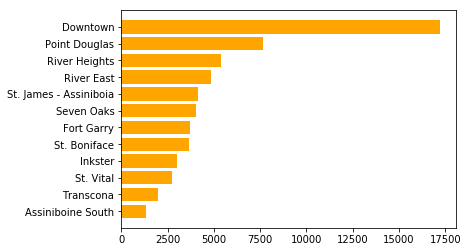

In [14]:
#Making a horizontal barchart of Community Crime levels
crimes_sorted = comm_crime.sort_values('Total_Crimes')
height, bars = crimes_sorted.Total_Crimes, crimes_sorted.Communities
y_pos = np.arange(len(bars))
 
plt.barh(y_pos, height, color='orange')
plt.yticks(y_pos, bars)

plt.show()

**Downtown** and **Point Douglas** have the highest crime levels, followed by notable crime-levels in **River Heights, River East, St. James..** and **Seven Oaks**. We will ignore these areas and focus our analysis on the other 6 Communities.

In [15]:
nh_filtered = nh_focus[~nh_focus['Community'].isin(['Downtown','Point Douglas','River Heights',
                                                     'River East','St. James - Assiniboia','Seven Oaks'])]

print('{} Neighborhoods with high crime levels dropped, there are now {} Neighborhoods in our dataframe'.format(len(nh_focus)-len(nh_filtered),len(nh_filtered)))

71 Neighborhoods with high crime levels dropped, there are now 37 Neighborhoods in our dataframe


### Map of Neighborhoods: Priority areas after filtering

In [16]:
new_map = folium.Map(location=[peglat, peglong], zoom_start=11)

#Getting a choropleth map describing crime-levels per community
crimes_map(comms_geo,comm_crime,new_map)
    
#Adding piority Neighborhood markers on the map
for lat, long, NH in zip(nh_filtered['Latitude'], nh_filtered['Longitude'], nh_filtered['Neighborhoods']):
        name = '{}'.format(NH)
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker([lat, long], radius = 5, popup = label, color = 'blue',
            fill = True, fill_color = 'pink', fill_opacity = 0.7, parse_html = False).add_to(new_map)
        
#Circle border
circle_border.add_to(new_map)

new_map

**Community comparison** of the counts of the Neighborhoods to be focused on:

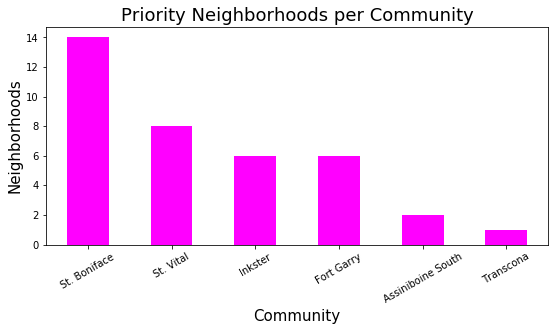

In [17]:
#Grouping Neighborhood counts by community
grouped_by_comm = nh_filtered.groupby('Community')['Neighborhoods'].count()
grouped_by_comm = grouped_by_comm.sort_values(ascending=False).plot.bar(figsize=(9,4), color='magenta')

plt.title('Priority Neighborhoods per Community', fontsize = 18)
plt.xlabel('Community', fontsize = 15)
plt.ylabel('Neighborhoods',fontsize = 15)
plt.xticks(rotation = 30)

plt.show()

## Finding Venues with Foursquare API
***
By calling on Fouresquare API, we will **locate venues** surrounding each Neighborhood at a radius of 500 meters. Then we will be able to see which Neighborhoods has more or less restaurants and markets. Note: In our analysis, anything related to places that provide food/drink supply for restaurants will be labelled "Suppliers"

In [18]:
#Inputting our latest dataframe into Fouresquare API to search for venues
nh_venues = foursquare_api(nh_filtered)

#Venues that are restaurants (with many types)
restaurants = nh_venues[nh_venues.Category.str.contains('Restaurant')]
diners = nh_venues[nh_venues.Category.str.contains('Diner')]
joints = nh_venues[nh_venues.Category.str.contains('Joint')]
place = nh_venues[nh_venues.Category.str.contains('Place')]

#Venues that are suppliers to restaurants (markets/groceries)
supermarkets = nh_venues[nh_venues.Category.str.contains('Super')]
groceries = nh_venues[nh_venues.Category.str.contains('Grocery')]
food_drink_shops = nh_venues[nh_venues.Category.str.contains('Food & Drink')]

#Total number of restaurants and suppliers (markets) respectively
suppliers = supermarkets.append(groceries).append(food_drink_shops).reset_index(drop=True)
all_restaurants = restaurants.append(diners).append(joints).append(place).reset_index(drop=True)
res_and_markets = all_restaurants.append(suppliers) #Dataframe with both restaurant and supplier totals

all_cat, res_num, supply_num = len(nh_venues.Category), len(all_restaurants), len(suppliers)
print('There are {} venues found, {} of them are restaurants and {} are suppliers.'.format(all_cat,res_num,supply_num))
nh_venues.head()

There are 200 venues found, 47 of them are restaurants and 10 are suppliers.


,Community,Neighborhoods,Latitude,Longitude,Venue,Venue_Lat,Venue_Long,Category
0,Assiniboine South,Edgeland,49.86811,-97.20859,Starbucks,49.867033,-97.211984,Coffee Shop
1,Assiniboine South,Edgeland,49.86811,-97.20859,Rady Jewish Community Centre,49.872103,-97.208858,Gym / Fitness Center
2,Assiniboine South,Edgeland,49.86811,-97.20859,Rumor's Restaurant & Comedy Club,49.867542,-97.213786,Comedy Club
3,Assiniboine South,Edgeland,49.86811,-97.20859,Safeway Tuxedo,49.866843,-97.212029,Grocery Store
4,Assiniboine South,Edgeland,49.86811,-97.20859,TD Canada Trust,49.866066,-97.212180,Bank


### Searching in our list of venues for Lebanese, Middle Eastern and Mediterranean restaurants

In [19]:
#Searching for any categories that are similar to Lebanese Restaurants
medit_res = nh_venues[nh_venues.Category.str.contains('Mediterranean')]
leb_res = nh_venues[nh_venues.Category.str.contains('Lebanese Restaurants {} ')]
mideast_res = nh_venues[nh_venues.Category.str.contains('Middle Eastern')]

print('Venues list identified by foursquare API have restaurants of type:\n{} - Lebanese, {} - Middle Eastern, and {} - Mediterranean'.format(len(leb_res), len(mideast_res),len(medit_res)))

Venues list identified by foursquare API have restaurants of type:
0 - Lebanese, 0 - Middle Eastern, and 1 - Mediterranean


The location of the Mediterranean restaurant found in our venues list is:

In [20]:
medit_res

,Community,Neighborhoods,Latitude,Longitude,Venue,Venue_Lat,Venue_Long,Category
51,Fort Garry,Parker,49.84718,-97.17913,Piazza Di Nardi,49.851063,-97.177872,Mediterranean Restaurant


### Map of Neighborhoods containing restaurants and food markets within 500m radius

In [21]:
res_map = folium.Map(location=[peglat, peglong], zoom_start=12)

venues_map(suppliers,res_map,'green') #Location markers for suppliers
venues_map(all_restaurants,res_map,'red') #Location markers for restaurants

#Circles centering Neighborhoods that contain the restaurants and suppliers
for lat, long, nh, comm in zip(res_and_markets.Latitude, res_and_markets.Longitude, 
                               res_and_markets.Neighborhoods, res_and_markets.Community):
    label = folium.Popup(str(nh)+' ({})'.format(str(comm))+'\n - 500m radius',parse_html=True)
    folium.Circle([lat,long], radius=500,popup=label,color='blue').add_to(res_map)
    
res_map

Retaurants are presented by red markers and Suppliers by green markers. The blue rings are circles centering on each Neighborhood at 500m radius.
From here we are able to see which Neighborhood contains more (or less) retaurant and supplier clusters than others.

### One-hot encoding and getting the mean of venue categories
Now one-hot enconding will be applied on venues listed by their categories that lie within each Neighborhood's radius

In [22]:
onehot_venues = onehot_encode(nh_venues)
onehot_venues.head()

,Community,Neighborhoods,Latitude,Longitude,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,...,Supermarket,Sushi Restaurant,Taco Place,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Warehouse Store,Wings Joint
0,Assiniboine South,Edgeland,49.86811,-97.20859,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Assiniboine South,Edgeland,49.86811,-97.20859,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Assiniboine South,Edgeland,49.86811,-97.20859,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Assiniboine South,Edgeland,49.86811,-97.20859,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Assiniboine South,Edgeland,49.86811,-97.20859,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we will find the mean of our one-hot_encoded values:

In [23]:
onehot_mean_venues = onehot_venues.groupby(['Community',"Neighborhoods"]).mean().reset_index()
onehot_mean_venues.head()

,Community,Neighborhoods,Latitude,Longitude,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,...,Supermarket,Sushi Restaurant,Taco Place,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Warehouse Store,Wings Joint
0,Assiniboine South,Edgeland,49.868110,-97.20859,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Assiniboine South,Old Tuxedo,49.869970,-97.21478,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Fort Garry,Parker,49.847180,-97.17913,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fort Garry,Point Road,49.847500,-97.14810,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Fort Garry,South Pointe,49.846777,-97.14436,0.0,0.0,0.0,0.0,0.500000,0.0,...,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


### Listing down the top 10 most common venues per Neighborhood
After obtaining the mean of our one-hot encoded venue categories, we will have a dataframe listing the top 10 most common venues in each neighborhood. 

In [24]:
common_venues = most_common_venues(onehot_mean_venues)
common_venues

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Assiniboine South,Edgeland,49.868110,-97.20859,Grocery Store,Café,Gym / Fitness Center,Bank,Pet Store,Pharmacy,Playground,Shipping Store,Shopping Mall,Comedy Club
1,Assiniboine South,Old Tuxedo,49.869970,-97.21478,Grocery Store,Gym / Fitness Center,Shipping Store,Greek Restaurant,Liquor Store,Comedy Club,Pet Store,Pharmacy,Playground,Café
2,Fort Garry,Parker,49.847180,-97.17913,Gym / Fitness Center,Italian Restaurant,Coffee Shop,Gourmet Shop,Mediterranean Restaurant,Sandwich Place,Breakfast Spot,Boutique,Fast Food Restaurant,Soccer Field
3,Fort Garry,Point Road,49.847500,-97.14810,Coffee Shop,Pizza Place,Sporting Goods Shop,Breakfast Spot,Fast Food Restaurant,Spa,Ramen Restaurant,Convenience Store,Athletics & Sports,Pharmacy
4,Fort Garry,South Pointe,49.846777,-97.14436,Athletics & Sports,Tennis Stadium,Wings Joint,Field,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store
5,Fort Garry,Wildwood,49.848230,-97.13313,Construction & Landscaping,Park,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store
6,Inkster,Brooklands,49.920970,-97.20179,Convenience Store,Recreation Center,Sandwich Place,Wings Joint,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Curling Ice,Department Store,Diner
7,Inkster,Pacific Industrial,49.912010,-97.17893,Coffee Shop,Clothing Store,Office,Burger Joint,Filipino Restaurant,Wings Joint,Event Space,Curling Ice,Department Store,Diner
8,Inkster,Shaughnessy Park,49.929130,-97.17461,Gym / Fitness Center,Comedy Club,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store,Event Space
9,Inkster,Weston,49.917970,-97.18641,Butcher,Sports Bar,Pizza Place,Wings Joint,Event Space,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Department Store


### Exploratory Data Analysis
We will be looking at Restaurants and Suppliers that are among the top most common venues in their respective Neighborhoods

In [25]:
common_counts = most_common_counts(common_venues)
#Dataframe of grouping the top venues sums by Community
comm_res = pd.DataFrame(common_counts.groupby('Community')['All_Restaurants'].sum()
                       ).sort_values(by=['All_Restaurants'],ascending=False)

comm_supp = pd.DataFrame(common_counts.groupby('Community')['All_Suppliers'].sum())

res_supp_counts = pd.merge(comm_res,comm_supp,on='Community')

print('Here we have the counts of Restaurants and Suppliers that belong in the top 10 most common venues.')
print('Dataframe of {} rows based on Neighborhood counts (left) || Dataframe based on Community-wise counts (right)'.format(len(common_counts)))
sbs([common_counts.head(7),res_supp_counts])

Here we have the counts of Restaurants and Suppliers that belong in the top 10 most common venues.
Dataframe of 32 rows based on Neighborhood counts (left) || Dataframe based on Community-wise counts (right)


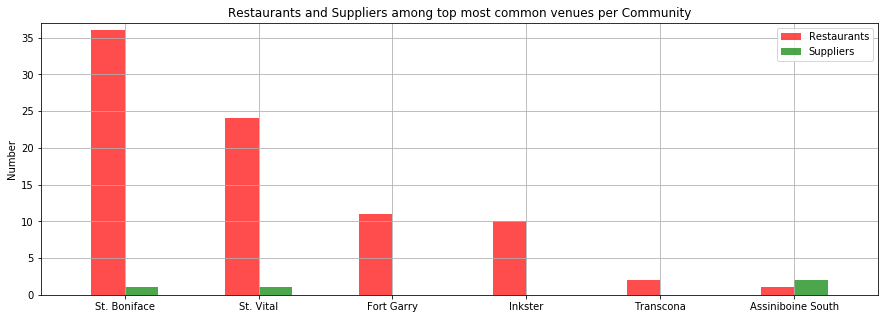

In [26]:
names = res_supp_counts.index.tolist()

#Positions and width for the bars
pos = list(range(len(res_supp_counts))) 
width = 0.25 
fig, ax = plt.subplots(figsize=(15,5))

#Barchart with position pos and width buffer
plt.bar([p + width for p in pos], res_supp_counts['All_Restaurants'],
        width, alpha=0.7, color='red') 

plt.bar([p + width*2 for p in pos], res_supp_counts['All_Suppliers'], 
        width, alpha=0.7, color='green') 

ax.set_ylabel('Number')
ax.set_title('Restaurants and Suppliers among top most common venues per Community')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(names)

plt.xlim(min(pos)-width, max(pos)+width*4) #x and y axis limits
plt.ylim([0, max(res_supp_counts['All_Restaurants'] + res_supp_counts['All_Suppliers'])] )

plt.legend(['Restaurants', 'Suppliers'], loc='upper')
plt.grid()
plt.show()

## Applying K-Means clustering on Neighborhoods
Here we will analyze the similarity in most common venue trends between Neighborhoods and then cluster similar Neighborhoods together  

In [27]:
clusters = onehot_mean_venues.copy()

clusters = clusters.drop(['Community', 'Neighborhoods','Latitude','Longitude'], 1)

k = 5
#Getting K-means clustering in our one-hot enconded means DF
Kmeans = KMeans(n_clusters = k, random_state = 0).fit(clusters)

#Common Venues DF that will describe each Neighborhood by a Cluster group eg; 0,1,2
common_clusters = common_venues.copy()
common_clusters.insert(0, 'Cluster_group', Kmeans.labels_)

common_clusters.sort_values(["Cluster_group"], inplace=True) #Sort DF by Cluster-group
common_clusters = common_clusters.reset_index(drop=True).drop(['All_Restaurants','All_Suppliers'],1)
common_clusters.head(7)

,Cluster_group,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Assiniboine South,Edgeland,49.86811,-97.20859,Grocery Store,Café,Gym / Fitness Center,Bank,Pet Store,Pharmacy,Playground,Shipping Store,Shopping Mall,Comedy Club
1,0,St. Vital,Varennes,49.85854,-97.11100,Convenience Store,Gas Station,Thai Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Fast Food Restaurant,Wings Joint,Electronics Store,Cosmetics Shop
2,0,St. Vital,St. George,49.84868,-97.10656,Coffee Shop,Board Shop,Pizza Place,Wings Joint,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner
3,0,St. Vital,Norberry,49.84196,-97.11431,Gym / Fitness Center,Bakery,Breakfast Spot,Fast Food Restaurant,Field,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store
4,0,St. Vital,Glenwood,49.86546,-97.10469,Argentinian Restaurant,Karaoke Bar,Sporting Goods Shop,Maternity Clinic,Wings Joint,Field,Cosmetics Shop,Curling Ice,Department Store,Diner
5,0,St. Vital,Elm Park,49.85583,-97.11844,Gym / Fitness Center,Soccer Field,Convenience Store,Bus Station,Mexican Restaurant,Fried Chicken Joint,Electronics Store,Golf Course,Cosmetics Shop,Curling Ice
6,0,St. Vital,Alpine Place,49.85450,-97.10174,Grocery Store,Curling Ice,Golf Course,Hotel,Coffee Shop,Gas Station,Fried Chicken Joint,Bakery,Bank,Bar


###  Map of our clustered Neighborhoods

In [28]:
clusters_map = folium.Map(location=[peglat, peglong], zoom_start=12)

#Getting color scheme for clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = [] #Adding markers
for lat, lon, comm, nh, cluster in zip(common_clusters['Latitude'], common_clusters['Longitude'], 
                        common_clusters['Community'], common_clusters['Neighborhoods'], 
                        common_clusters['Cluster_group']):
    
    label = folium.Popup('{} ({}) - Cluster {}'.format(comm, nh, cluster), parse_html=True)
    
    folium.CircleMarker( [lat, lon], radius=5, popup=label, color=rainbow[cluster-2], 
    fill=True, fill_color=rainbow[cluster-2], fill_opacity=0.7).add_to(clusters_map)
       
clusters_map

### Getting a look at the clustered Neighborhoods groups
We can analyze what similar trends do Neighborhoods have in their clustered groups

In [29]:
common_clusters[common_clusters.Cluster_group == 0].iloc[:,1:15] #Cluster 0

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Assiniboine South,Edgeland,49.868110,-97.20859,Grocery Store,Café,Gym / Fitness Center,Bank,Pet Store,Pharmacy,Playground,Shipping Store,Shopping Mall,Comedy Club
1,St. Vital,Varennes,49.858540,-97.11100,Convenience Store,Gas Station,Thai Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Fast Food Restaurant,Wings Joint,Electronics Store,Cosmetics Shop
2,St. Vital,St. George,49.848680,-97.10656,Coffee Shop,Board Shop,Pizza Place,Wings Joint,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner
3,St. Vital,Norberry,49.841960,-97.11431,Gym / Fitness Center,Bakery,Breakfast Spot,Fast Food Restaurant,Field,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store
4,St. Vital,Glenwood,49.865460,-97.10469,Argentinian Restaurant,Karaoke Bar,Sporting Goods Shop,Maternity Clinic,Wings Joint,Field,Cosmetics Shop,Curling Ice,Department Store,Diner
5,St. Vital,Elm Park,49.855830,-97.11844,Gym / Fitness Center,Soccer Field,Convenience Store,Bus Station,Mexican Restaurant,Fried Chicken Joint,Electronics Store,Golf Course,Cosmetics Shop,Curling Ice
6,St. Vital,Alpine Place,49.854500,-97.10174,Grocery Store,Curling Ice,Golf Course,Hotel,Coffee Shop,Gas Station,Fried Chicken Joint,Bakery,Bank,Bar
7,St. Boniface,Windsor Park,49.863720,-97.07636,Convenience Store,Restaurant,Automotive Shop,Event Space,Wings Joint,Fast Food Restaurant,Cosmetics Shop,Curling Ice,Department Store,Diner
8,St. Boniface,Tissot,49.894730,-97.10799,Gym / Fitness Center,Spa,Bowling Alley,Breakfast Spot,Coffee Shop,French Restaurant,Ice Cream Shop,Sandwich Place,American Restaurant,Theater
9,St. Boniface,Stock Yards,49.874270,-97.08731,Grocery Store,Convenience Store,Moving Target,Bowling Alley,Construction & Landscaping,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store


In [30]:
common_clusters[common_clusters.Cluster_group == 1].iloc[:,1:15] #Cluster 1

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,St. Vital,Victoria Crescent,49.83966,-97.12818,Pet Store,Wings Joint,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store


In [31]:
common_clusters[common_clusters.Cluster_group == 2].iloc[:,1:15] #Cluster 2

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,St. Boniface,Norwood West,49.87543,-97.12797,Park,Wings Joint,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store
28,Fort Garry,Wildwood,49.84823,-97.13313,Construction & Landscaping,Park,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store
29,St. Boniface,North St. Boniface,49.89681,-97.12040,Park,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store


In [32]:
common_clusters[common_clusters.Cluster_group == 3].iloc[:,1:15] #Cluster 3

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Inkster,Shaughnessy Park,49.92913,-97.17461,Gym / Fitness Center,Comedy Club,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store,Event Space


In [33]:
common_clusters[common_clusters.Cluster_group == 4].iloc[:,1:15] #Cluster 4

,Community,Neighborhoods,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,St. Vital,Kingston Crescent,49.85368,-97.13147,Bus Station,Field,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Department Store,Diner,Discount Store,Electronics Store


**Cluster 0**: Most Neighborhoods from every Community (all from Assiniboine South and the one from Transcona) fall in this cluster. These Neighborhoods can be described as business areas, since common venues include Coffee shops, Banks, Grocery stores, Pharmacies, Fitness Centers, and a mix of other venues.

**Cluster 1**: This cluster describes a unique Neighborhood in St. Vital where the top most common venue would be Pet stores, followed by restaurants and several stores.

**Cluster 2**: This group has top common venues as Parks, Construction sites, followed by restaurants, Convenience stores and various other stores.

**Cluster 3**: Shaughnessy Park has a unique trend. Here we see that the top venues revolve around Gym/Fitness Center, followed by Comedy club and various stores.

**Cluster 4**: Another unique neighborhood trend in St.Vital, where Bus Stations are the 1st most common venue, followed by fields, restaurants and stores. 

## Results and Discussion <a name="results"></a>

We have reached the end of our analysis, having gathered interesting results from our selected Communities and Neighborhoods. With many valuable tools like the geocoder library, sklearn's KMeans clustering, folium maps and foursquare API, we have exercised data exploration and analysis with our business problem conditions, and have found the following:

* One Mediterranian restaurant was found in Parker (Fort Garry), where as other neighborhoods don't have similar restaurant themes to Lebanese.

* The community St. Bonafice dominates in the density of restaurants among it's top most common venues, followed by St. Vital. Where as Assiniboine South ranks the lowest in this case.

* Assiniboine South has the highest density of food markets among it's top most common venues. St. Bonafice and St. Vital have food markets in very low density compared to restaurants among their most common venues, where as the other Neighborhoods have none among their common venues.

* Some Neighborhoods belonging to all the Communities fall under cluster 1, where all of Assiniboine South's Neighboods are in.


From the above insights, we can see that the Assiniboine South community would have the least competition for the launch of a new restaurant, as it has Grocery stores among it's Neighborhood's top most common venues, with Greek Restaurant being the 4th most common venue in the neighborhood - Old Tuxedo. The top 3 competitive Neighborhoods would be of those in St. Bonafice, St.Vital and Fort Garry. Not only do most Neighborhoods have average restaurant density in St.Bonafice and St.Vital, they are also close to each other and accumulate to a high density level in restaurants with less supply assets (groceries/markets) among their most common venues. Looking at the Neighborhoods in Fort Garry, the Mediterranian restaurant would clash with our Lebanese theme, posing as competition. 
The Neighborhoods in Inkster and one in Transcona have an average density in restaurants as common venues, however there aren't any supply assets among their common venues. So these Communities would also pose as competition. 

We can say that the Neighborhoods in Assiniboine South would seem to be the best candidates for opening a restaurant in from our analysis. With K-means clustering we gethered information on similarities in most common venues between Neighborhoods. An advantage to opening a restaurant in Assiniboine South is that it belongs to the cluster group that identifies as a business area, where you would be surrounded by Banks, Shopping Malls and Playgrounds. There would be a good frequency of potential customers around such places. 

Some drawbacks of this analysis — Due to limited data, the focus of our analysis involved only factors such as personal safety per location (crime levels per community) and venues obtained from Foursquare data. We're nearing the end of 2019, the crimes data obtained from Winnipeg Police's annual report is based on 2018. Crime levels per community might have changed significantly this year but the annual report for 2019 or any up-to date Winnipeg crime report is yet to be presented.
There are many other factors that can affect the success of businesses, such as land price, distance of venues from public transport stations, population of potential customers in a neighborhood/comunity etc. 

The recommended Neighborhood/Community in this project should only be looked at as a starting point for more detailed analysis. Having all other relevant factors met, we would have more realistic and favorable insights that may fit all of our business problem conditions in opening a restaurant.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify Neighborhoods in Winnipeg near Downtown with good safety levels, low density of restaurants (with no similar themes as our restaurant) and near food markets that would help stakeholders in deciding on the ideal location for opening a new Lebanese restaurant. Calculating distances of Neighborhoods using the Haversine formula was a valuable tool in segmenting Neighborhoods. Data on crimes per community obtained from Winnipeg Police's Annual report gave us an idea of the levels of personal safety among communities. Venues data obtained from Foursquare API helped identify the most common venues near Neighborhoods, from which we brought exploratory analysis of Neighborhoods and Communities based on density distribution of restaurants and food markets. 
And finally applying K-means clustering for finding similar venue trends between Neighborhoods gave us an idea of what other benefits a candidate Neighborhood/Community would have for us in opening a restaurant based on it's venue trends.

This project gave us some important preliminary information on the possibilities of opening a new restaurant around a recommended a area. There was a detailed discussion on the drawbacks of having limited data for analysis, where with more factors presented for our task would bring more realistic results and a clearer picture of the performance of a potential business in a chosen area. 

This project was a real eye-opener for me, I feel rewarded with the efforts, time and money spent. I got a good exposure of how Data Science tools can be used in solving real life situations that would have an impact on business performance. I would highly recommend anyone to get the same Data Science experience in this program. A big thanks to the Coursera Team and fellow Students!

Cheers